# Imports

In [30]:
import numpy as np

import os
import sys

import data_visualisation as dv

# Loading Data

In [1]:
# Path to the data
brugada_path = 'DAT China/DAT China Brugada ECGs/dat'
RBBB_path = 'DAT China/DAT China RBBB ECGs/datnew'
Normal_path = 'DAT China/Normal/dat'

In [5]:
def load_china_data(dir_path, label):
    
    # init array
    data = []
    
    # read all files in the directory
    for file in os.listdir(dir_path):
        path = os.path.join(dir_path, file)
        f = open(path, 'r')
        ecg = np.fromfile(f, dtype=np.int16)
        ecg = np.reshape(ecg, (8, 5000))
        
        ## Downsample to 100hz
        ecg = ecg.reshape(8, 1000, 5)
        ecg = np.mean(ecg, axis=2)
        
        data.append(ecg)
        f.close()
        
    # Convert to numpy array
    data = np.array(data)
    # Reshape to (n_samples, n_samples_per_lead, n_leads)
    data = np.swapaxes(data, 1, 2)
    
    # Calculate remaining leads
    lead_III = data[:,:,1] - data[:,:,0]           # ecg_dict['III'] = ecg_dict['II'] - ecg_dict['I']
    lead_aVR = -0.5 * (data[:,:,0] + data[:,:,1])  # ecg_dict['aVR'] = -0.5 * (ecg_dict['I'] + ecg_dict['II'])
    lead_aVL = data[:,:,0] - 0.5 * data[:,:,1]     # ecg_dict['aVL'] = ecg_dict['I'] - 0.5 * ecg_dict['II']
    lead_aVF = data[:,:,1] - 0.5 * data[:,:,0]     # ecg_dict['aVF'] = ecg_dict['II'] - 0.5 * ecg_dict['I']
    
    # Add remaining leads to data
    data = np.concatenate((data,  
                              np.expand_dims(lead_III, axis=2), 
                              np.expand_dims(lead_aVR, axis=2), 
                              np.expand_dims(lead_aVL, axis=2), 
                              np.expand_dims(lead_aVF, axis=2)), axis=2)
    
    return data, np.full(data.shape[0], label)

# Load the data

In [9]:
Normal_data, normal_labels = load_china_data(Normal_path, 0)
brugada_data, brugada_labels = load_china_data(brugada_path, 1)
RBBB_data, RBBB_labels = load_china_data(RBBB_path, 2)

print("Normal:", Normal_data.shape)
print("Brugada:", brugada_data.shape)
print("RBBB:", RBBB_data.shape)

Normal: (9998, 1000, 12)
Brugada: (176, 1000, 12)
RBBB: (10000, 1000, 12)


# Visualizing a sample

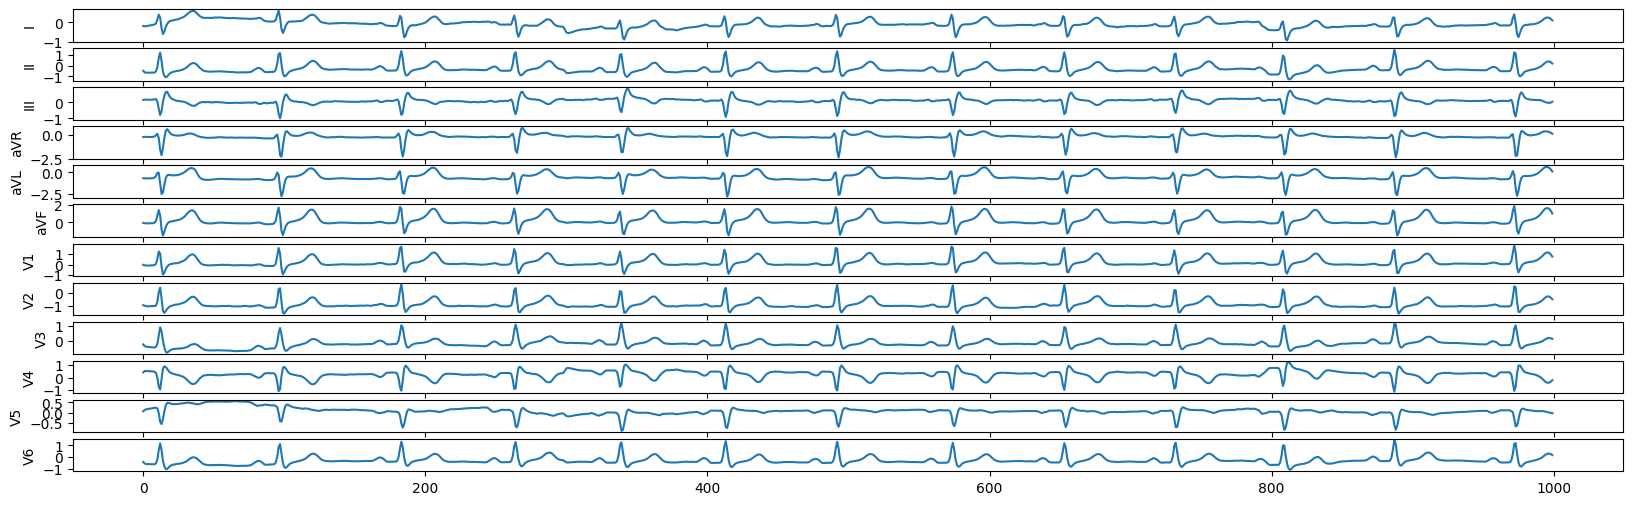

In [16]:
rand_sample = brugada_data[np.random.randint(0, brugada_data.shape[0])]

dv.plot_12_lead_ecg(rand_sample)

# Preprocessing

In [15]:
# Normalise data
from sklearn.preprocessing import StandardScaler

all_data = np.concatenate((Normal_data, brugada_data, RBBB_data), axis=0)
scaler = StandardScaler()
sclaer = scaler.fit(all_data.reshape(-1, all_data.shape[-1]))

Normal_data = scaler.transform(Normal_data.reshape(-1, Normal_data.shape[-1])).reshape(Normal_data.shape)
brugada_data = scaler.transform(brugada_data.reshape(-1, brugada_data.shape[-1])).reshape(brugada_data.shape)
RBBB_data = scaler.transform(RBBB_data.reshape(-1, RBBB_data.shape[-1])).reshape(RBBB_data.shape)


In [20]:
# Downsmaple classes
RBBB_data = RBBB_data[np.random.choice(RBBB_data.shape[0], brugada_data.shape[0], replace=False)]
Normal_data = Normal_data[np.random.choice(Normal_data.shape[0], 2*brugada_data.shape[0], replace=False)]

print("Normal:", Normal_data.shape)
print("Brugada:", brugada_data.shape)
print("RBBB:", RBBB_data.shape)

Normal: (352, 1000, 12)
Brugada: (176, 1000, 12)
RBBB: (176, 1000, 12)


# Shuffle the data

In [21]:
# shuffle data
np.random.shuffle(Normal_data)
np.random.shuffle(RBBB_data)
np.random.shuffle(brugada_data)

data = np.concatenate((Normal_data, RBBB_data, brugada_data), axis=0)
labels = np.concatenate((normal_labels[:Normal_data.shape[0]], RBBB_labels[:RBBB_data.shape[0]], brugada_labels), axis=0)

fnc = lambda x: "Normal" if x == 0 else "Brugada" if x == 2 else "RBBB"
text_labels = np.array([fnc(label) for label in labels])

print("\nData shape:", data.shape)
print("Labels shape:", labels.shape)
print("Text labels shape:", text_labels.shape)

# shuffle data
permutation = np.random.permutation(data.shape[0])
np.random.shuffle(permutation)

shuffled_data = data[permutation]
shuffled_labels = labels[permutation]


Data shape: (704, 1000, 12)
Labels shape: (704,)
Text labels shape: (704,)


# Create a train and test split

In [25]:
test_split = 0.2

test_split = int(data.shape[0] * test_split)

X_train = shuffled_data[test_split:]
Y_train = shuffled_labels[test_split:]
Y_train_text = text_labels[test_split:]

X_test = shuffled_data[:test_split]
Y_test = shuffled_labels[:test_split]
Y_test_text = text_labels[:test_split]

# label distribution
print("\nTrain label distribution:")
print("Total:", Y_train.shape[0])
print("Normal:", np.sum(Y_train == 0), "(", np.sum(Y_train == 0) / Y_train.shape[0], "%)")
print("Brugada:", np.sum(Y_train == 1), "(", np.sum(Y_train == 1) / Y_train.shape[0], "%)")
print("RBBB:", np.sum(Y_train == 2), "(", np.sum(Y_train == 2) / Y_train.shape[0], "%)")

print("\nTest label distribution:")
print("Total:", Y_test.shape[0])
print("Normal:", np.sum(Y_test == 0), "(", np.sum(Y_test == 0) / Y_test.shape[0], "%)")
print("Brugada:", np.sum(Y_test == 1), "(", np.sum(Y_test == 1) / Y_test.shape[0], "%)")
print("RBBB:", np.sum(Y_test == 2), "(", np.sum(Y_test == 2) / Y_test.shape[0], "%)")


Train data shape: (564, 1000, 12)
Train labels shape: (564,)
Train text labels shape: (564,)

Test data shape: (140, 1000, 12)
Test labels shape: (140,)
Test text labels shape: (140,)

Train label distribution:
Total: 564
Normal: 278 ( 0.4929078014184397 %)
Brugada: 143 ( 0.25354609929078015 %)
RBBB: 143 ( 0.25354609929078015 %)

Test label distribution:
Total: 140
Normal: 74 ( 0.5285714285714286 %)
Brugada: 33 ( 0.2357142857142857 %)
RBBB: 33 ( 0.2357142857142857 %)


# Save Data

In [28]:
NP_DATA_LR = 'data/DAT_China.npz'

save_args = {
    'X_train': X_train,
    'Y_train': Y_train,
    'Y_train_text': Y_train_text,
    'X_test': X_test,
    'Y_test': Y_test,
    'Y_test_text': Y_test_text
}

np.savez(NP_DATA_LR, **save_args)

# Load Data

In [31]:
thismodule = sys.modules[__name__]
NP_DATA = 'data/DAT_China.npz'

with np.load(NP_DATA, allow_pickle=True) as data:
    for k in data.keys():
        if 'text' in k:
            setattr(thismodule, k, data[k])
        else:
            setattr(thismodule, k, data[k].astype(float))